# The plan

I was wondering how to continue this project still building upon what I was doing in the previous modules: mesh simplification. I wanted to try and devise a statistical machine learning pipeline to predict better simplification steps, but as I hadn't enough time to grow my idea (and I would need to generate a lot of data, maybe even manually labelled), I decided on another thing - use develop using machine learning a mesh segmentation algorithm which to use in a pipeline in conjunction with a heuristic which chooses the highly detailed clusters from the mesh to be preserved better during simplification (at least this is my ambition, we will see how much of the work I can get done). A short resume will follow on what I want to do in a bit more detail.

For this project, I aim to enhance 3D mesh simplification by leveraging machine learning techniques to prioritize the preservation of high-detail regions. The project will focus on applying clustering algorithms to segment a mesh into meaningful clusters and then using these clusters to guide the simplification process. 

First, I will construct a similarity matrix for the mesh faces based on features such as geodesic distances, Shape Diameter Function (SDF), and dihedral angles (representing concavities). The methodology for this step is inspired by the paper "[3D Mesh Segmentation Based on Multiclass Spectral Graph Partition](https://www.researchgate.net/publication/261428678_3D_Mesh_Segmentation_Based_on_Multiclass_Spectral_Graph_Partition)." This matrix will serve as input to clustering algorithms, enabling segmentation of the mesh into distinct regions.

Next, I will experiment with several clustering algorithms from scikit-learn, including Spectral Clustering, DBSCAN, etc., as these support precomputed affinity matrices. To optimize the clustering process, I will use Hyperopt to fine-tune algorithm parameters, aiming to match segmentation benchmarks available for the meshes in my dataset "[A Benchmark for 3D Mesh Segmentation](https://segeval.cs.princeton.edu/)". 

To identify high-detail clusters, I will implement heuristics that prioritize areas of high curvature, vertex density, or regions characterized by SDF and dihedral angle analysis. These clusters will then influence the simplification algorithm, which will penalize simplifications in high-detail regions, preserving their fidelity.

Finally, I will evaluate this enhanced simplification approach using both visual inspections and quantitative metrics, such as vertex count, triangle count, and fidelity metrics like Hausdorff Distance. I try to compare the results against baseline segmentations and simplifications without segmentation guidance, using datasets such as **Thingi10K** for testing if I have the time.

I will try my best and see what I can do from the plan until the deadline hits.

A bit about the construction of the similarity matrix for 3D mesh segmentation:

The similarity matrix is a crucial component for segmenting a 3D mesh using spectral graph partitioning (in the paper they use spectral clustering written by them, while I use sklearn implementation). The process involves defining a weighted graph where the nodes represent faces of the mesh, and the edges denote the similarity between pairs of faces. Here's an overview of the method:

#### 1. **Geometric Features**
To compute the similarity matrix, three geometric features are extracted for each face in the mesh:

- **Geodesic Distance**:
  - Represents the shortest path between the centres of two faces along the surface of the mesh.
  - Only the geodesic distances between a face and its nearest neighbours (within a radius $r$) are considered to reduce computational cost and memory usage.
  - The geodesic distance is normalized by the average geodesic distance.

- **Concavities**:
  - Quantifies the boundaries of the mesh using dihedral angles between adjacent faces.
  - The concavity between two faces is calculated as the sum of dihedral angles along the shortest geodesic distance path connecting them.

- **Shape Diameter Function (SDF)**:
  - Provides volumetric information by computing the average ray length from the centre of a face to intersections with the opposite side of the mesh. 
  - The *absolute* difference in SDF values between two faces is accumulated along the shortest geodesic distance path.

#### 2. **Weight Calculation**
The edge weights in the graph are computed using a Gaussian similarity function:
\begin{equation*}
w_{i,j} = 
\begin{cases} 
\exp\left(-\frac{G_{ij}^2}{2\sigma_1^2}\right) \cdot \exp\left(-\frac{S_{ij}^2}{2\sigma_2^2} - \frac{C_{ij}^2}{2\sigma_3^2}\right), & \text{if } G_{ij} \leq r, \\
0, & \text{otherwise}.
\end{cases}
\end{equation*}
Where:
- $ G_{ij} $: Geodesic distance between faces $ f_i $ and $ f_j $.
- $ S_{ij} $: Accumulated SDF difference along the geodesic path.
- $ C_{ij} $: Accumulated concavity along the geodesic path.
- $ \sigma_1, \sigma_2, \sigma_3 $: Gaussian kernel widths, set to the maximum values of $ G_{ij}, S_{ij}, C_{ij} $, respectively.

#### 3. **Sparse Matrix Construction**
To avoid the computational burden of a dense similarity matrix:
- Only geodesic neighbours within the radius $ r $ are included.
- The radius $ r $ is set as $ \sqrt{0.005 \cdot \text{area}(S)} $, where $ \text{area}(S) $ is the total surface area of the mesh. I will try to optimize it as a hyperparameter.

It is said in the paper that this method ensures that the similarity matrix captures meaningful relationships while remaining computationally efficient.

Here is a visualization of the vectors which will be generated for the sdf calculations.

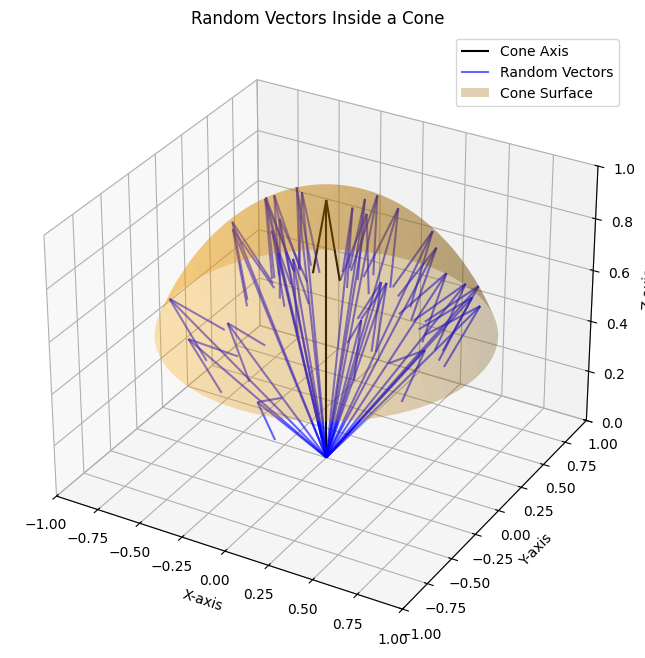

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Cone parameters
cone_angle = np.radians(120)  # 45 degrees for visualization
num_vectors = 30            # Number of vectors to generate

# Generate random vectors inside the cone
vectors = []
for _ in range(num_vectors):
    z = np.random.uniform(np.cos(cone_angle / 2), 1)
    theta = np.random.uniform(0, 2 * np.pi)
    x = np.sqrt(1 - z**2) * np.cos(theta)
    y = np.sqrt(1 - z**2) * np.sin(theta)
    vectors.append((x, y, z))

vectors = np.array(vectors)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the cone's axis
ax.quiver(0, 0, 0, 0, 0, 1, color='black', label='Cone Axis')

# Plot the vectors inside the cone
ax.quiver(
    np.zeros(len(vectors)),
    np.zeros(len(vectors)),
    np.zeros(len(vectors)),
    vectors[:, 0],
    vectors[:, 1],
    vectors[:, 2],
    color='blue',
    alpha=0.6,
    label='Random Vectors'
)

# Plot the cone's surface for reference
theta = np.linspace(0, 2 * np.pi, 100)
z = np.linspace(np.cos(cone_angle / 2), 1, 50)
theta_grid, z_grid = np.meshgrid(theta, z)
r_grid = np.sqrt(1 - z_grid**2)
x_grid = r_grid * np.cos(theta_grid)
y_grid = r_grid * np.sin(theta_grid)

ax.plot_surface(x_grid, y_grid, z_grid, color='orange',
                alpha=0.3, label='Cone Surface')

# Set plot limits and labels
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 1])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Random Vectors Inside a Cone')

ax.legend()
plt.show()